In [1]:
import ete3
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import subprocess
from scipy.stats import spearmanr, linregress
import itertools
from Bio import SeqIO, SearchIO, AlignIO, Align, Alphabet
import re
import multiprocessing
from copy import deepcopy

class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

os.chdir('/work/site_rate/hemimastigophora')
ncbi        = ete3.NCBITaxa()
num_threads = 10

In [4]:
subprocess.call(['iqtree', '-s', '6_concatenated alignments/CAT_61tax_h0.42_g1.bmge.fas', '-keep-ident',
                 '-nt', '15', '-redo', '-m', 'LG+C60+F+I+G12' , '-safe', '-wsr',
                 '-te', 'CAT_61tax_h0.42_g1.bmge.fas.UFboot.tre', '-pre', 'rate_binning'])

KeyboardInterrupt: 

In [12]:
alignment = AlignIO.read('6_concatenated alignments/CAT_61tax_h0.42_g1.bmge.fas', 'fasta')
alignment.get_alignment_length()

93903

In [23]:
rates     = pd.read_table('rate_binning.rate', comment='#')
invariable_sites = rates[rates.Cat == 0].index.tolist()
rates.drop(labels=invariable_sites, axis='index', inplace=True)

alignment = AlignIO.read('6_concatenated alignments/CAT_61tax_h0.42_g1.bmge.fas', 'fasta')
for category in rates.Cat.unique():
    site_df        = rates[rates.Cat == category]
    category_aln   = {}
    for sequence in alignment:
        category_aln[sequence.name] = ''.join([sequence[position] for position in site_df.index])

    out = open('categories/%i.aln' % category, 'w')
    for header, sequence in category_aln.items():
        full_sequence = ''
        while len(full_sequence) <= 93903:
            full_sequence += sequence
        out.write('>%s\n%s\n' % (header, full_sequence[:93903]))
    out.close()

In [43]:
np.percentile(rates['Rate'].tolist(), 20)

0.12774800000000003

In [57]:
print category_frequencies[-1:]
sum(category_frequencies[-3:])

[6.786790624367699]


24.004557894848936

1 2462
2 8218
3 6282
4 6177
5 6059
6 6435
7 6834
8 7256
9 7392
10 7528
11 8640
12 6373


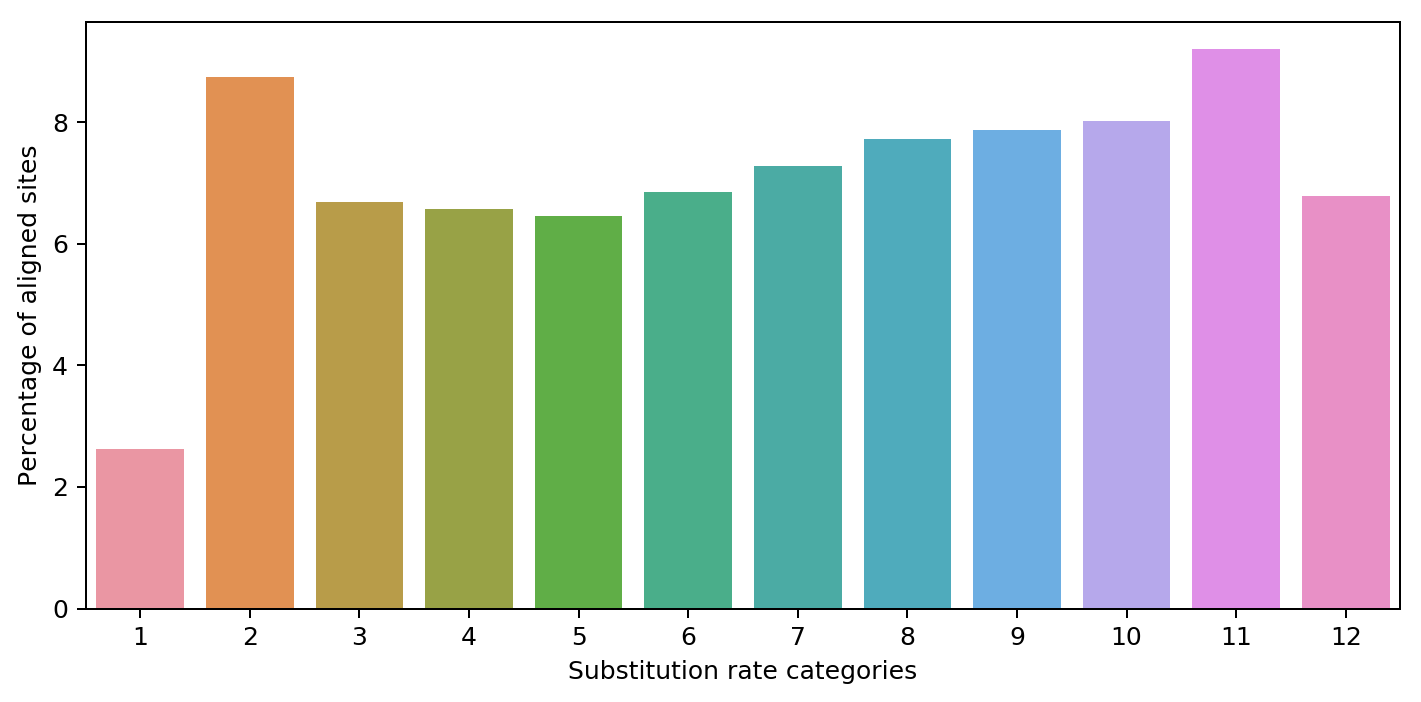

In [32]:
rates     = pd.read_table('rate_binning.rate', comment='#')
category_frequencies = []
for category in range(1,13):
    category_length = sum(rates.Cat==category)
    category_frequencies.append((category_length/93903.)*100)
    print category, category_length

fig, ax = plt.subplots(dpi=180, figsize=(8,4))
sns.barplot(x=range(1,13), y=category_frequencies)
ax.set_xlabel('Substitution rate categories')
ax.set_ylabel('Percentage of aligned sites')
fig.tight_layout()

In [ ]:
def run_bootstrap(category):
    subprocess.call(['iqtree', '-s', '%i.aln' % category, '-m', 'LG+C60+F+G', '-redo',
                     '-safe', '-nt', '1', '-pre', '%i' % category,
                     '-alrt', '1000', '-keep-ident', '-quiet', '-te', '../CAT_61tax_h0.42_g1.bmge.fas.UFboot.tre'])


with cd('rate_categories'):
    pool = multiprocessing.Pool(processes=12)
    pool.map(run_bootstrap, range(1, num_categories+1))

In [2]:
reference_tree        = ete3.Tree('CAT_61tax_h0.42_g1.bmge.fas.UFboot.tre')
reference_tree.children[0]

Tree node 'AcanGEN' (0x109c0a09)

In [10]:
branch_lengths = np.asarray([node.dist for node in reference_tree.traverse()
                             if not node.is_leaf() and not node.is_root()])
branch_lengths[branch_lengths < 0.006753].shape


(1,)

In [20]:
number_of_categories  = 12
category_support_df   = pd.DataFrame(columns='category topology_id support branch_length'.split())
tree                  = ete3.Tree('CAT_61tax_h0.42_g1.bmge.fas.UFboot.tre')
for category in range(1, number_of_categories+1):
    print category
    
    tmp_tree = ete3.Tree('categories/%i.treefile' %category)
    tmp_tree.set_outgroup('AcanGEN')

    tmp_supports       = []
    tmp_topology_ids   = []
    tmp_branch_lengths = []
    for node in tmp_tree.traverse():
        if not node.is_leaf() and not node.is_root():
            tmp_supports.append(node.support)
            tmp_topology_ids.append(node.get_topology_id())
            tmp_branch_lengths.append(node.dist)

    tmp_df = pd.DataFrame(
                zip([category]*len(tmp_supports),
                    tmp_topology_ids,
                    tmp_supports,
                    tmp_branch_lengths),
                columns='category topology_id support branch_length'.split())
    category_support_df = category_support_df.append(tmp_df)

for node in tree.traverse():
    if not node.is_leaf() and not node.is_root():
        tmp_topology_id = node.get_topology_id()
        category_support_df.loc[category_support_df.topology_id == tmp_topology_id, 'branch_length'] = node.dist

category_support_df.to_csv('category_supports.tab', sep='\t')

1
2
3
4
5
6
7
8
9
10
11
12


In [21]:
branch_lengths = category_support_df.loc[
    category_support_df.category == 1,
    'branch_length'.split()].values.squeeze()

branch_length_bins = [np.percentile(branch_lengths, decile) for decile in range(10, 91, 10)]
binning            = np.digitize(category_support_df['branch_length'].values.squeeze(), branch_length_bins)
bin_names          = {}

for bin in set(binning):
    min_binned_branch_len = category_support_df.loc[binning==bin, 'branch_length'].values.squeeze().min()
    max_binned_branch_len = category_support_df.loc[binning==bin, 'branch_length'].values.squeeze().max()
    bin_names[bin]        = '%.2e - %.2e' % (min_binned_branch_len, max_binned_branch_len)

category_support_df['branch_length_bin'] = [bin_names[bin] for bin in binning]

/Users/thiberio/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


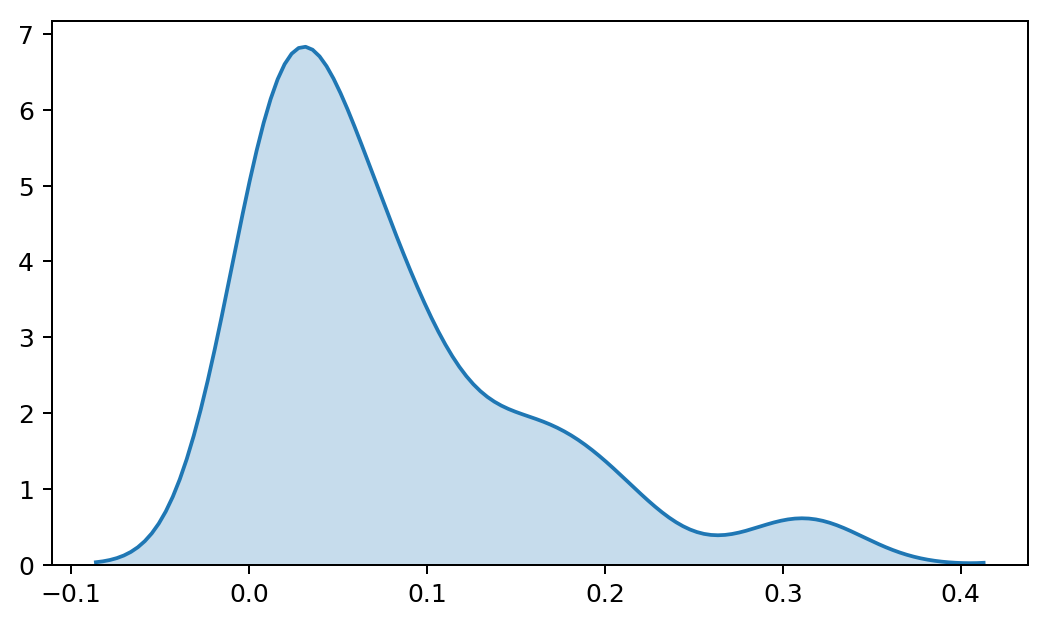

In [22]:
fig, ax = plt.subplots(dpi=180)
sns.kdeplot(branch_lengths, shade=True, ax=ax)
fig.set_size_inches(7,4)

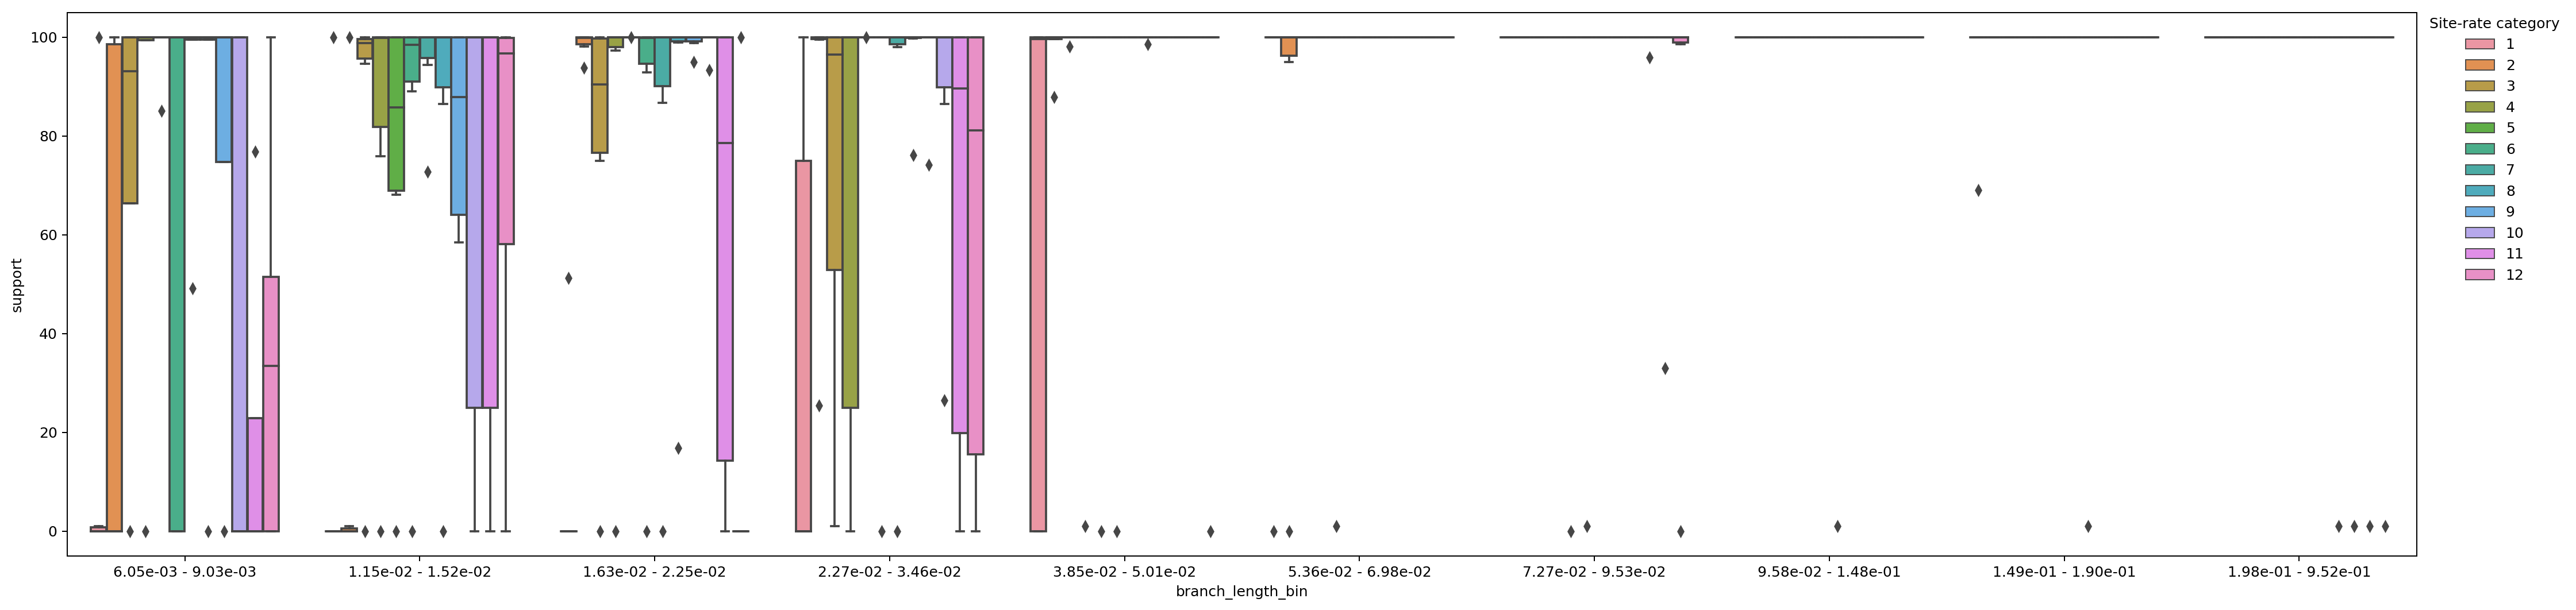

In [24]:
fig, ax = plt.subplots(dpi=180)
sns.boxplot(x='branch_length_bin', y='support', hue='category', order=bin_names.values(), data=category_support_df, ax=ax)
fig.set_size_inches(25,6)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.015), title='Site-rate category',frameon=False)
fig.tight_layout()
#fig.savefig('support_binned_by_branch_length-decile_binned.pdf', dpi=300)
#plt.close()